In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import motive
import utils
import oe

In [2]:
date = "20250915" # change this according to ur session
animal = "eb03"

oe_sr = 30000
m_sr = 120

_, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)

pitch_path = Path(res_path) / "pitch"
pitch_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


In [3]:
goodspiketimes = oe.ks_load(ks_path)
with open(Path(f'{res_path}/preprocessing') / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
51 phy-good clusters


In [4]:
csv_dict = motive.get_csv_dict(csv_path)
with open(Path(f'{res_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)
meta

{'of1': '20250915_6', 'of2': '20250915_9', 'of3': '20250915_11'}

In [5]:
with open(Path(res_path) / "preprocessing" / f"smooth_pitch_dict_{date}.pkl", "rb") as f:
    smooth_pitch_dict = pickle.load(f)
smooth_pitch_dict

{'sigma': 3,
 'of1': array([-14.32173518, -14.52565968, -14.88774034, ...,  67.77152655,
         67.86577198,  67.91625916], shape=(216405,)),
 'of2': array([-15.57267155, -15.54803812, -15.50474833, ..., -27.51964333,
        -27.44572961, -27.40607677], shape=(181549,)),
 'of3': array([ 0.05805385,  0.22093619,  0.56315965, ..., 50.17631907,
        50.24276233, 50.28701872], shape=(180367,))}

In [45]:
trial_key = 'of3'
df = csv_dict[meta[trial_key]]

In [46]:
start, end = periods[trial_key]
goodspiketimes_period = {
    unit: spikes[(spikes >= start) & (spikes <= end)] - start
    for unit, spikes in goodspiketimes.items()
}
goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

In [47]:
t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']

_,_,v = motive.speed(x, z, t)

pitch = smooth_pitch_dict[trial_key]*(-1)

t.shape, x.shape, y.shape, z.shape, pitch.shape, v.shape

((180367,), (180367,), (180367,), (180367,), (180367,), (180367,))

-88.58890718272441 78.0609332636821


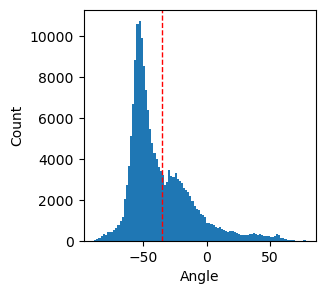

In [48]:
a = -35

plt.figure(figsize=(3,3))
plt.hist(pitch, bins=100)
plt.axvline(a, color='red', linestyle='--', linewidth=1)
plt.xlabel('Angle')
plt.ylabel('Count')
print(pitch.min(), pitch.max())
plt.show()

In [49]:
speed_cutoff = 0.02 # 2cm/s
pitch_borders = [-90,a, 90]#[-90,-30, 90]

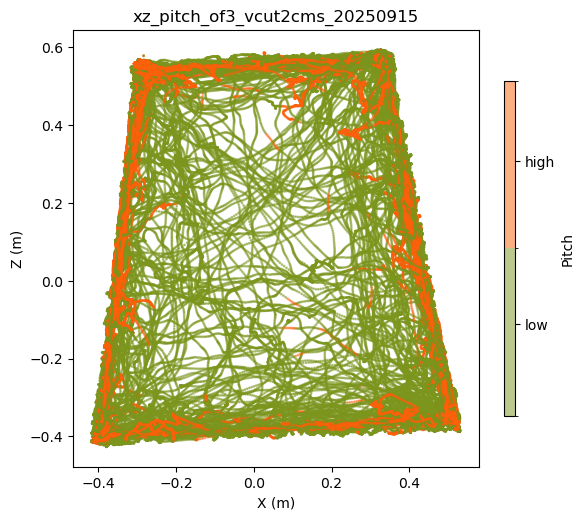

In [50]:
from matplotlib.colors import ListedColormap, BoundaryNorm

labels = ['low', 'high']
cmap = ListedColormap(['#7B951D', '#FC600A'])
norm = BoundaryNorm(pitch_borders, cmap.N, clip=True)
plt.figure(figsize=(6,6))
sc = plt.scatter(x, z, c=pitch, cmap=cmap, norm=norm, s=1, alpha=0.5)
tick_positions = [(-90 + -30)/2, (-30 + 90)/2]  # midpoints
cbar = plt.colorbar(sc, ticks=tick_positions,shrink=0.6, aspect=30)
# shrink=0.6 → 60% of original height
# aspect=10  → makes it slimmer (higher number = thinner bar)
cbar.ax.set_yticklabels(labels)
cbar.set_label('Pitch')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
filename = f'xz_pitch_{trial_key}_vcut{int(speed_cutoff*100)}cms_{date}'
plt.title(filename)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_17444/1493926491.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(x[mask], z[mask], c=color, s=1, alpha=0.5)
/tmp/ipykernel_17444/1493926491.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


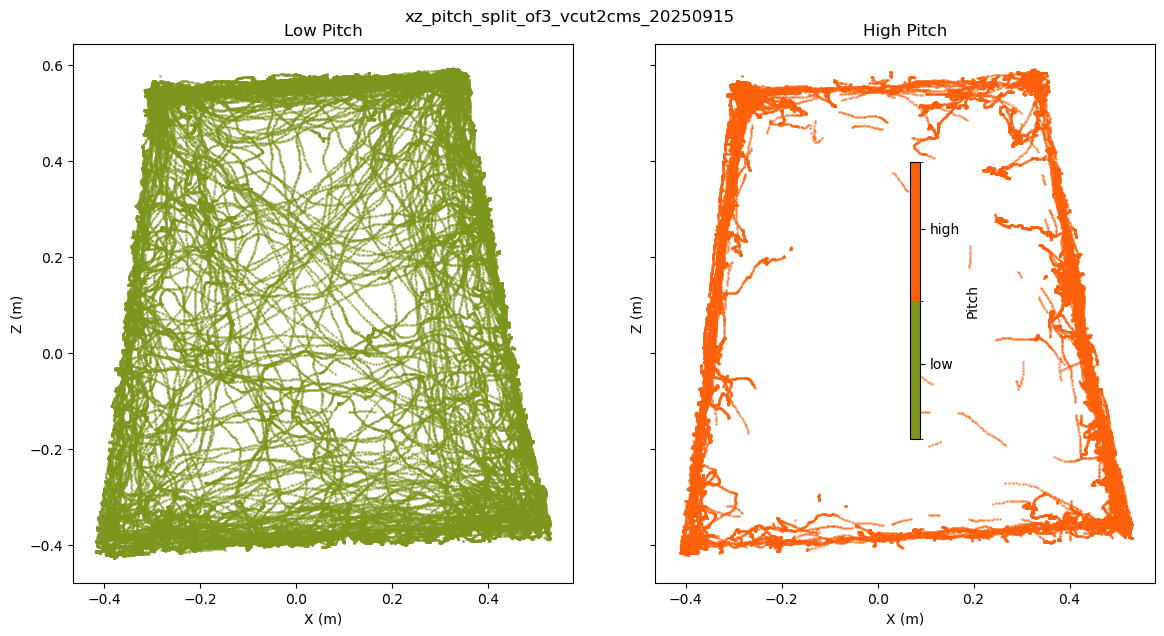

In [51]:
labels = ['low', 'high']
cmap = ListedColormap(['#7B951D', '#FC600A'])
norm = BoundaryNorm(pitch_borders, cmap.N, clip=True)

# Prepare subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Filter low and high pitch data
low_mask = (pitch >= pitch_borders[0]) & (pitch < pitch_borders[1])
high_mask = (pitch >= pitch_borders[1]) & (pitch <= pitch_borders[2])

# Define plotting function
def plot_subset(ax, mask, label, color):
    sc = ax.scatter(x[mask], z[mask], c=color, s=1, alpha=0.5)
    ax.set_title(label)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_aspect('equal', adjustable='box')
    return sc

# Plot each subset
plot_subset(axs[0], low_mask, 'Low Pitch', cmap(0))
plot_subset(axs[1], high_mask, 'High Pitch', cmap(1))

# Shared colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=axs.ravel().tolist(), orientation='vertical',
    shrink=0.6, aspect=30, ticks=[-60, 30]
)
cbar.ax.set_yticklabels(labels)
cbar.set_label('Pitch')

# Finalize
filename = f'xz_pitch_split_{trial_key}_vcut{int(speed_cutoff*100)}cms_{date}'
fig.suptitle(filename)
plt.tight_layout()
plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()


In [52]:
# oe data resampling - samples of 120freq with spike events
spikes_resampled = {unit: (spikes*m_sr).astype(int) for unit, spikes in goodspiketimes_sec.items()}

In [53]:
speed_mask = v>speed_cutoff
pitch_labels = ['low_pitch', 'high_pitch']

pitch_idx = np.digitize(pitch, bins=pitch_borders) - 1  # bin index per frame

In [54]:
pf_data_dict = {}

# spatial bin edges
bin_size = 0.05 # 5cm
eps = 1e-9  # to avoid division by zero 
x_edges = np.arange(x.min(), x.max()  + bin_size, bin_size)
z_edges = np.arange(z.min(), z.max()  + bin_size, bin_size)

pf_data_dict['x_edges'] = x_edges
pf_data_dict['z_edges'] = z_edges


for bin_i, label in enumerate(pitch_labels):

    mask = speed_mask & (pitch_idx == bin_i)

    # Apply mask to your position & spike data
    x_masked = x[mask]
    z_masked = z[mask]

    # occupancy
    occupancy_counts, _, _ = np.histogram2d(x_masked, z_masked, bins=[x_edges, z_edges])
    occupancy_seconds = occupancy_counts/m_sr # time spent per bin (s)

    from scipy.ndimage import gaussian_filter
    sigma = 1.0
    occupancy_smooth  = gaussian_filter(occupancy_seconds, sigma=sigma)
    occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0)
    occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)
    pf_data_dict[(label, 'om')] = occupancy_smooth_masked

    for cell_id, spike_idxs in spikes_resampled.items():
        # guard: keep indices in range
        spike_idxs = spike_idxs[spike_idxs < mask.size]

        # select spikes that occur in frames of this pitch+speed mask
        spikes_in_bin = mask[spike_idxs]           # boolean per spike
        spike_frames  = spike_idxs[spikes_in_bin]  # frame indices in this bin

        # positions at those spikes
        sx = x[spike_frames]
        sz = z[spike_frames]

        # spike map (counts)
        sp_counts, _, _ = np.histogram2d(sx, sz, bins=[x_edges, z_edges])

        # smooth spike map
        spike_map_smooth = gaussian_filter(sp_counts, sigma=sigma)
        spike_map_smooth_masked = np.where(occupancy_mask, np.nan, spike_map_smooth)
        pf_data_dict[(label, 'sm', cell_id)] = spike_map_smooth_masked

        # rate map (Hz) = counts / seconds
        rm = spike_map_smooth_masked / occupancy_smooth_masked
        pf_data_dict[(label, 'rm', cell_id)] = rm

In [55]:
import matplotlib.cm as cm

def plot_occupancy_maps(vmin=None, vmax=None, cmap='viridis'):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axs = axes.ravel()

    # Safely create colormap and set NaN color
    if cmap == 'viridis':
        cmap_mod = cm.viridis.copy()
    else:
        cmap_mod = cm.get_cmap(cmap)
    cmap_mod.set_bad(color='lightgrey')

    # compute common vmin/vmax if not provided
    if vmin is None or vmax is None:
        vals = [pf_data_dict[(label, 'om')] for label in pitch_labels]
        all_vals = np.concatenate([v.ravel() for v in vals if v is not None])
        vmin = np.nanpercentile(all_vals, 1)
        vmax = np.nanpercentile(all_vals, 99)
        '''
        This sets the color scale between the 1st and 99th percentiles.
        Why not min and max?
        Outliers (e.g. a very high firing rate in one bin) can distort the color range.
        This keeps the colormap robust and comparable across panels.
        '''

    for ax, label in zip(axs, pitch_labels):
        occ_map = pf_data_dict[(label, 'om')]
        occ_map = np.ma.masked_invalid(occ_map.T)
        im = ax.imshow(occ_map,
                       origin='lower',
                       extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]],
                       aspect='equal',
                       cmap=cmap_mod,
                       vmin=vmin, vmax=vmax)
        ax.set_title(label)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')

    cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.8, aspect=20)
    cbar.set_label('Occupancy (s)')

    filename = f'om_{trial_key}_vcut{int(speed_cutoff*100)}cms_{date}'
    fig.suptitle(filename, fontsize=12)
    plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

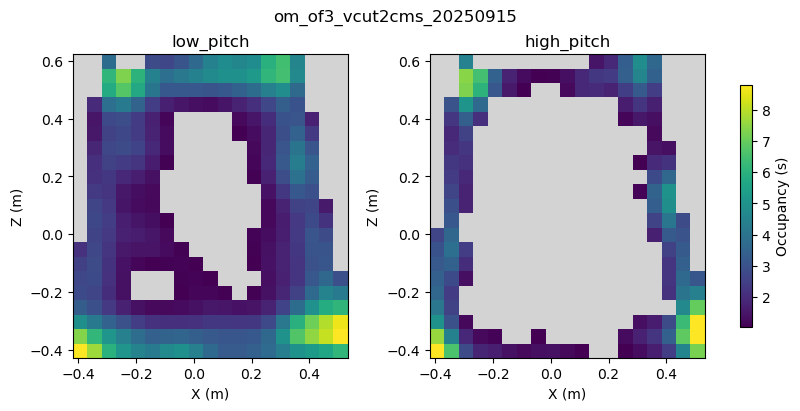

In [56]:
plot_occupancy_maps()

In [57]:
def plot_spike_maps_for_cell(cell_id, vmin=None, vmax=None, cmap='Reds', save=True):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axs = axes.ravel()

    # Create safe colormap
    cmap_mod = cm.Reds.copy() if cmap == 'Reds' else cm.get_cmap(cmap)
    cmap_mod.set_bad(color='lightgrey')

    # Compute shared vmin/vmax across labels
    if vmin is None or vmax is None:
        vals = []
        for label in pitch_labels:
            try:
                vals.append(pf_data_dict[(label, 'sm', cell_id)])
            except KeyError:
                continue
        if vals:  # Avoid crash if list is empty
            all_vals = np.concatenate([v.ravel() for v in vals])
            vmin = np.nanpercentile(all_vals, 1)
            vmax = np.nanpercentile(all_vals, 99)
        else:
            vmin, vmax = 0, 1  # fallback

    # Plot spike maps
    for ax, label in zip(axs, pitch_labels):
        try:
            sp_map = pf_data_dict[(label, 'sm', cell_id)]
            sp_map = np.ma.masked_invalid(sp_map.T)

            im = ax.imshow(sp_map,
                           origin='lower',
                           extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]],
                           aspect='equal', cmap=cmap_mod, vmin=vmin, vmax=vmax)
        except KeyError:
            ax.set_visible(False)  # if no data, hide axis
            continue

        ax.set_title(label)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')

    # Add colorbar only if at least one imshow succeeded
    if 'im' in locals():
        cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.8, aspect=20)
        cbar.set_label('Spike count')

    filename = f'sm_unit{cell_id}_{trial_key}_vcut{int(speed_cutoff*100)}cms_{date}'
    fig.suptitle(filename, fontsize=12)

    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')

    if cell_id == list(spikes_resampled.keys())[0]:
        plt.show()
    plt.close()

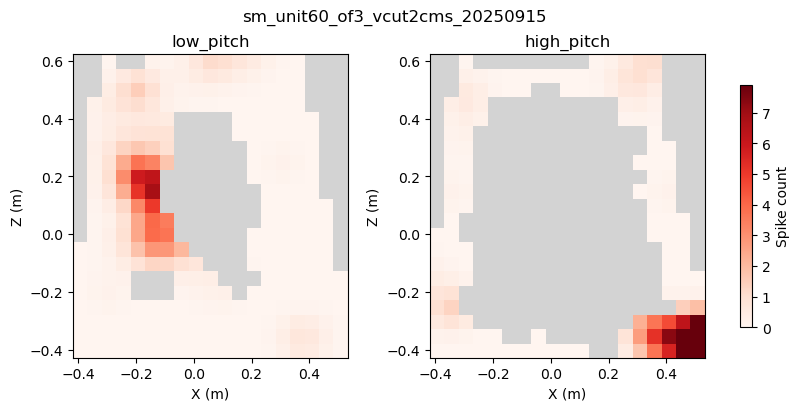

In [58]:
for unit in spikes_resampled.keys():
    plot_spike_maps_for_cell(unit, vmin=None, vmax=None, cmap='Reds')

In [59]:
def plot_rate_maps_for_cell(cell_id, vmin=None, vmax=None, cmap='Spectral_r', save=True):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axs = axes.ravel()

    # Create safe colormap
    cmap_mod = cm.Spectral_r.copy() if cmap == 'Spectral_r' else cm.get_cmap(cmap)
    cmap_mod.set_bad(color='lightgrey')

    # Compute shared vmin/vmax across labels
    if vmin is None or vmax is None:
        vals = []
        for label in pitch_labels:
            try:
                vals.append(pf_data_dict[(label, 'rm', cell_id)])
            except KeyError:
                continue
        if vals:  # Avoid crash if list is empty
            all_vals = np.concatenate([v.ravel() for v in vals])
            vmin = np.nanpercentile(all_vals, 1)
            vmax = np.nanpercentile(all_vals, 99)
        else:
            vmin, vmax = 0, 1  # fallback

    # Plot spike maps
    for ax, label in zip(axs, pitch_labels):
        try:
            r_map = pf_data_dict[(label, 'rm', cell_id)]
            r_map = np.ma.masked_invalid(r_map.T)

            im = ax.imshow(r_map,
                           origin='lower',
                           extent=[x_edges[0], x_edges[-1], z_edges[0], z_edges[-1]],
                           aspect='equal', cmap=cmap_mod, vmin=vmin, vmax=vmax)
        except KeyError:
            ax.set_visible(False)  # if no data, hide axis
            continue

        ax.set_title(label)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')

    # Add colorbar only if at least one imshow succeeded
    if 'im' in locals():
        cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.8, aspect=20)
        cbar.set_label('Spike count')

    filename = f'pf_unit{cell_id}_{trial_key}_vcut{int(speed_cutoff*100)}cms_{date}'
    fig.suptitle(filename, fontsize=12)

    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')

    if cell_id == list(spikes_resampled.keys())[0]:
        plt.show()
    plt.close()

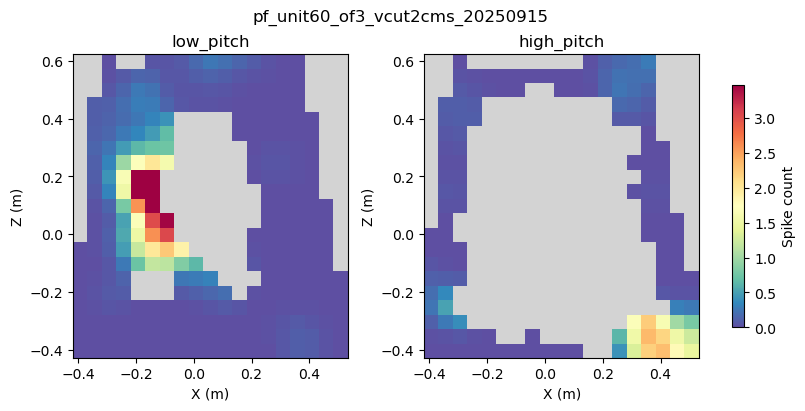

In [60]:
for unit in spikes_resampled.keys():
    plot_rate_maps_for_cell(unit, vmin=None, vmax=None, cmap='Spectral_r')

In [61]:
with open(f"{pitch_path}/pf_data_dict_{trial_key}_{date}.pkl", "wb") as f:
    pickle.dump(pf_data_dict, f)